In [1]:
import pandas as pd

# Load Data
path = '/kaggle/input/bank-marketing/bank-additional-full.csv'
df = pd.read_csv(path, sep=';')

# Analysis
print(df.shape)
df.info()
print(df.describe())
print(df.describe(include=['O']))
print(df.isnull().sum())
print(df.duplicated().sum())

(41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   411

Counts of unknown values per column
job: 330 (0.8%)
marital: 80 (0.19%)
education: 1731 (4.2%)
default_status: 8597 (20.87%)
housing: 990 (2.4%)
loan: 990 (2.4%)

Target Class Distribution
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

pdays Value Counts
pdays
999    39673
3        439
6        412
4        118
9         64
Name: count, dtype: int64


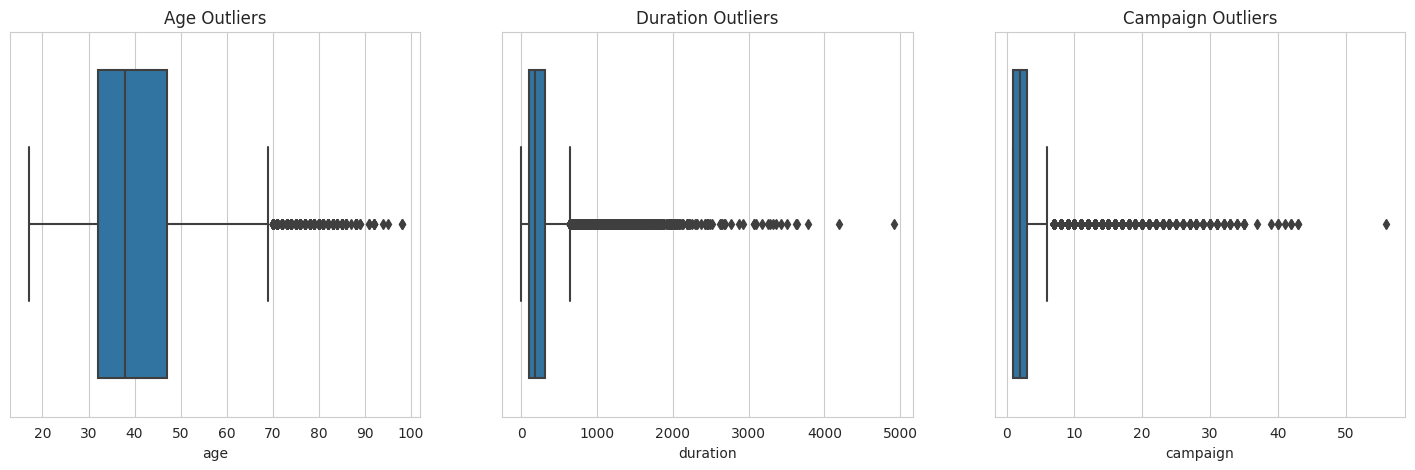

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check for 'unknown' values in categorical columns
print("Counts of unknown values per column")
for col in df.columns:
    if df[col].dtype == 'object':
        count = df[df[col] == 'unknown'][col].count()
        if count > 0:
            print(f"{col}: {count} ({round(count/len(df)*100, 2)}%)")

# 2. Check Class Imbalance
print("\nTarget Class Distribution")
print(df['y'].value_counts(normalize=True))

# 3. Check pdays (999 indicates not contacted)
print("\npdays Value Counts")
print(df['pdays'].value_counts().head())

# 4. Visualize Outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x=df['age'], ax=axes[0])
axes[0].set_title('Age Outliers')

sns.boxplot(x=df['duration'], ax=axes[1])
axes[1].set_title('Duration Outliers')

sns.boxplot(x=df['campaign'], ax=axes[2])
axes[2].set_title('Campaign Outliers')

plt.show()

In [7]:
import sqlite3
import pandas as pd

# 1. Clean Column Names to make them SQL-safe
# Replace dots with underscores (e.g., 'emp.var.rate' -> 'emp_var_rate')
df.columns = [c.replace('.', '_') for c in df.columns]

# Rename 'default' to 'default_status' to avoid SQL keyword conflict
df.rename(columns={'default': 'default_status'}, inplace=True)

# 2. Setup In-Memory SQL Engine
conn = sqlite3.connect(':memory:')
df.to_sql('bank_raw', conn, index=False, if_exists='replace')

# 3. SQL Feature Engineering Query
# Note: We now use the clean column names (default_status, emp_var_rate, etc.)
query = """
SELECT 
    age, job, marital, education, default_status, housing, loan,
    campaign, pdays, previous, poutcome,
    emp_var_rate, cons_price_idx, cons_conf_idx, euribor3m, nr_employed,
    
    -- 1. Create Age Segments
    CASE 
        WHEN age < 30 THEN 'Young'
        WHEN age BETWEEN 30 AND 50 THEN 'Middle-Aged'
        ELSE 'Senior' 
    END AS age_group,
    
    -- 2. Transform Call Duration into Categories
    CASE 
        WHEN duration < 180 THEN 'Short'
        WHEN duration BETWEEN 180 AND 600 THEN 'Medium'
        ELSE 'Long' 
    END AS duration_category,
    
    -- 3. Previous Contact Behavior (pdays=999 means not contacted)
    CASE 
        WHEN pdays = 999 THEN 0 
        ELSE 1 
    END AS is_previously_contacted,
    
    -- 4. Target Encoding
    CASE 
        WHEN y = 'yes' THEN 1 
        ELSE 0 
    END AS target

FROM bank_raw
"""

# 4. Execute and Export
df_engineered = pd.read_sql(query, conn)
conn.close()

# Verify
print("Feature Engineering Complete")
print(f"Shape: {df_engineered.shape}")
print(df_engineered[['age_group', 'duration_category', 'target']].head())

Feature Engineering Complete
Shape: (41188, 20)
     age_group duration_category  target
0       Senior            Medium       0
1       Senior             Short       0
2  Middle-Aged            Medium       0
3  Middle-Aged             Short       0
4       Senior            Medium       0


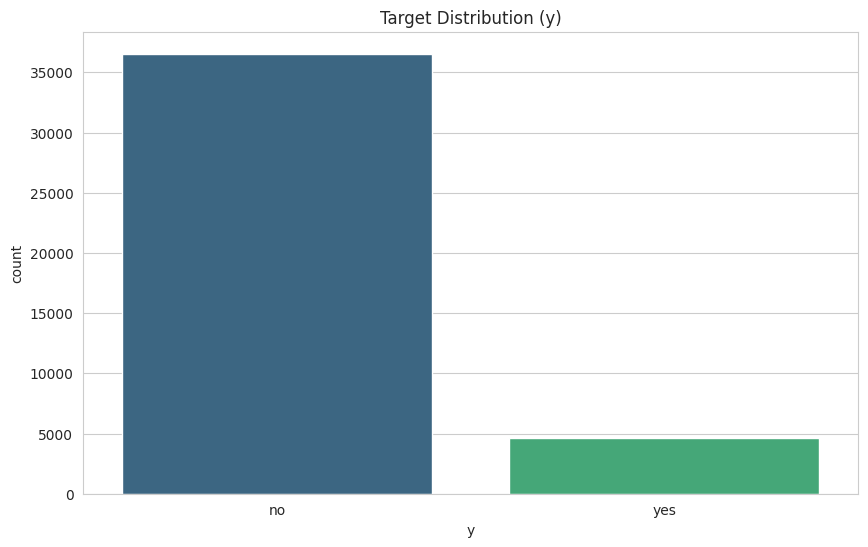

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


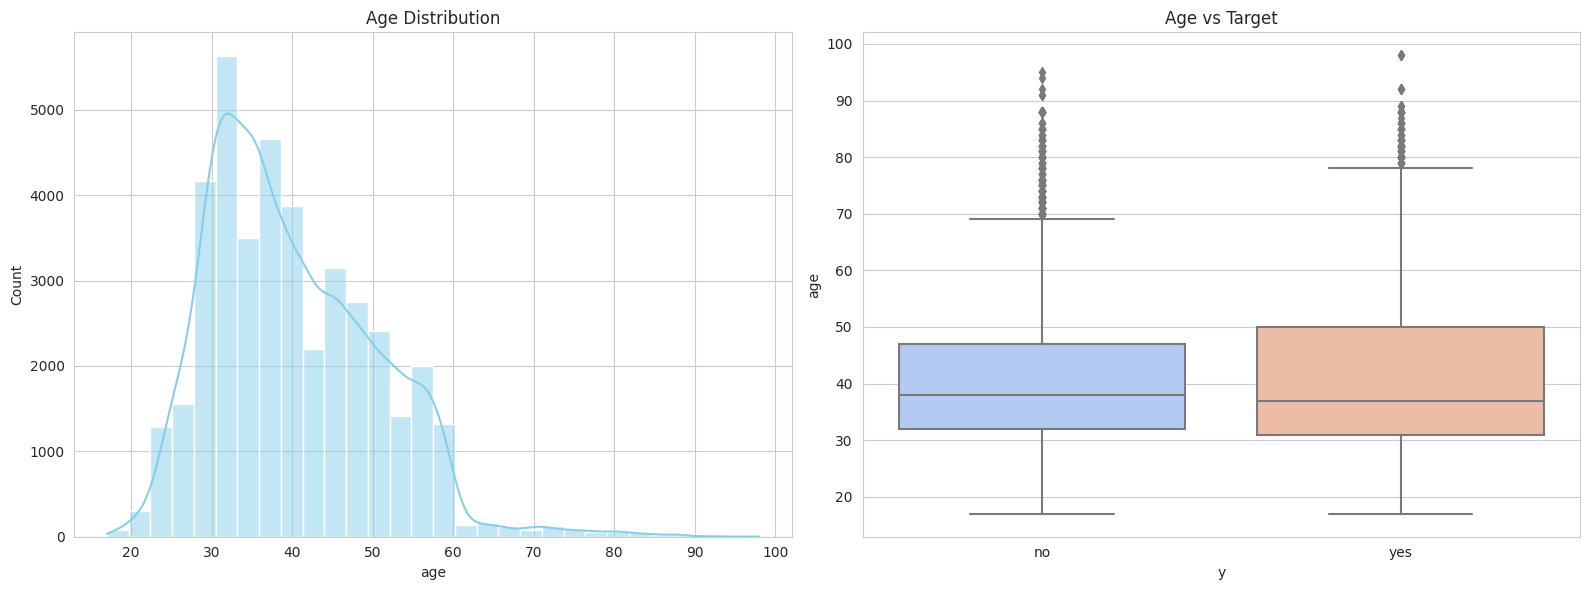

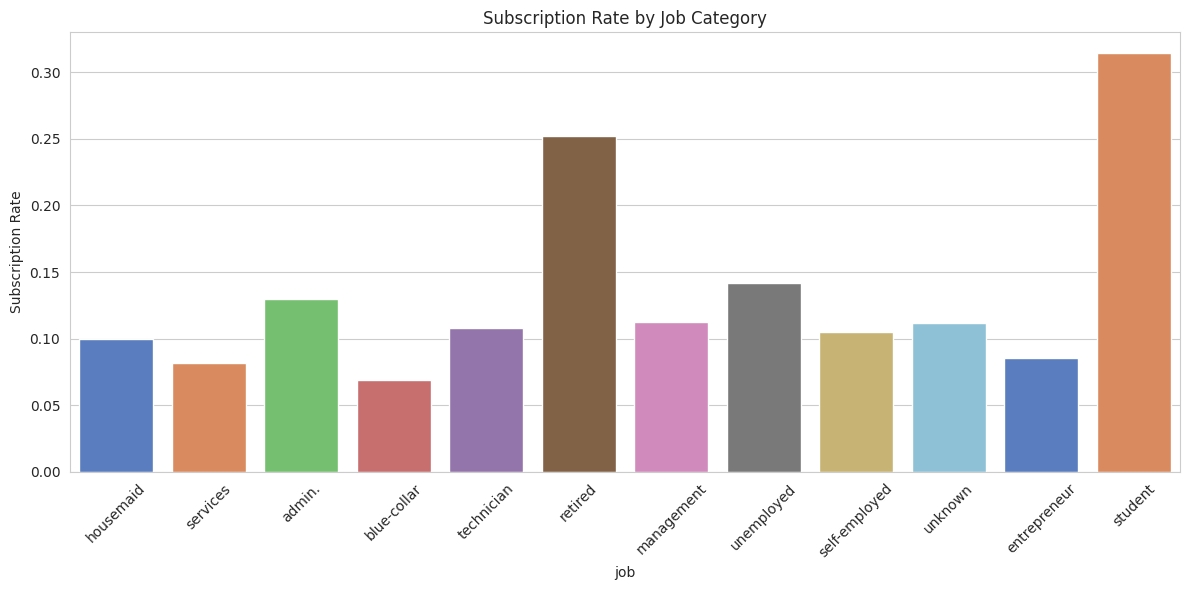

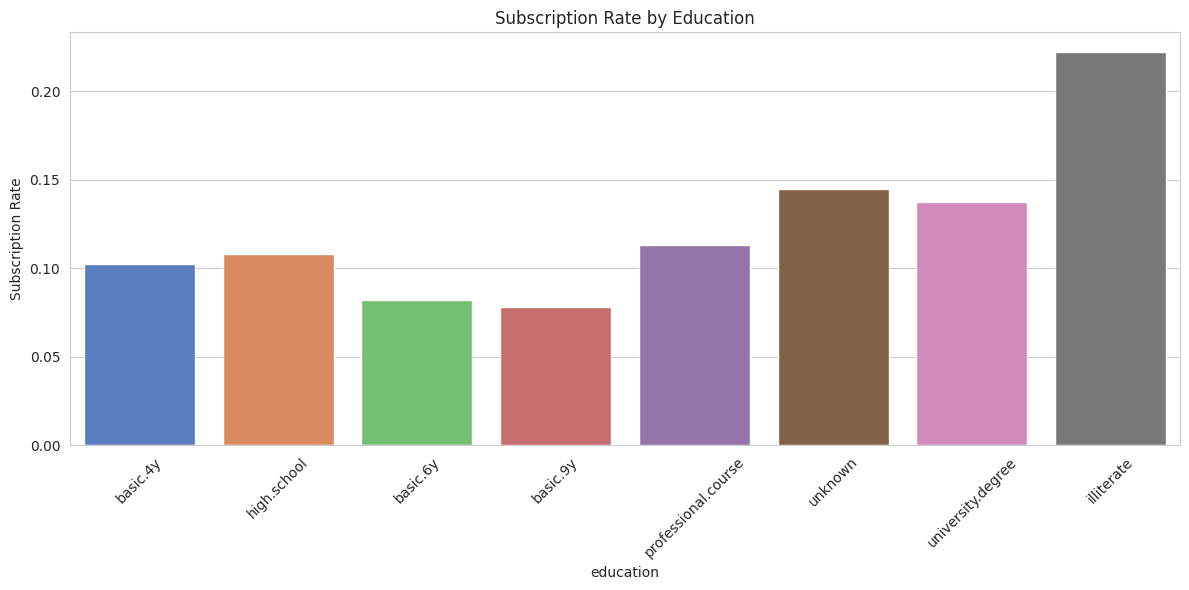

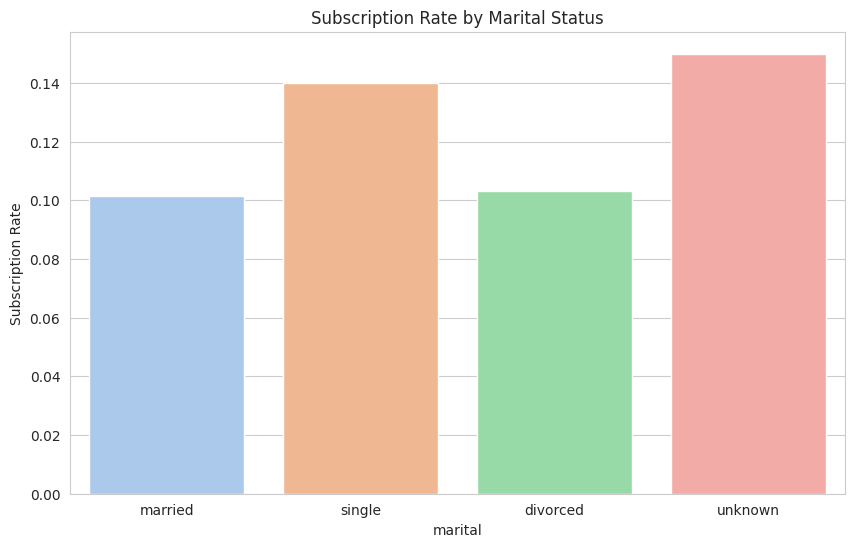

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


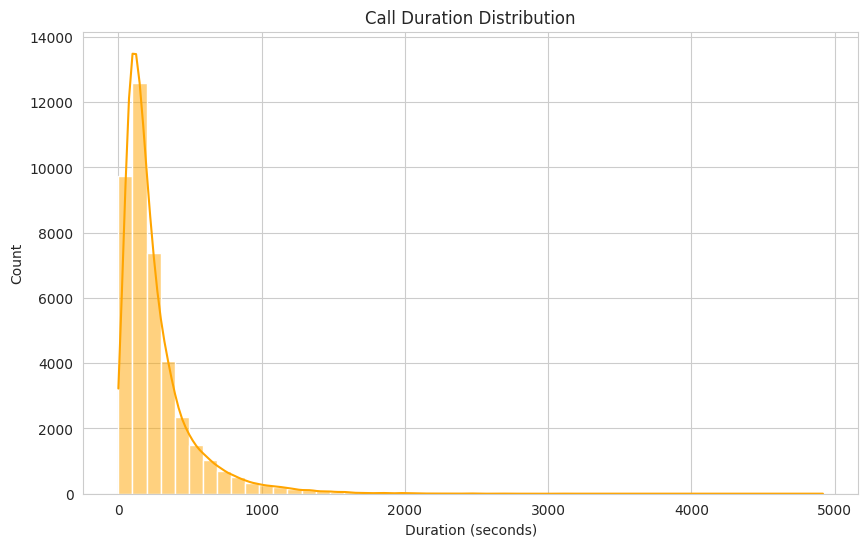

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


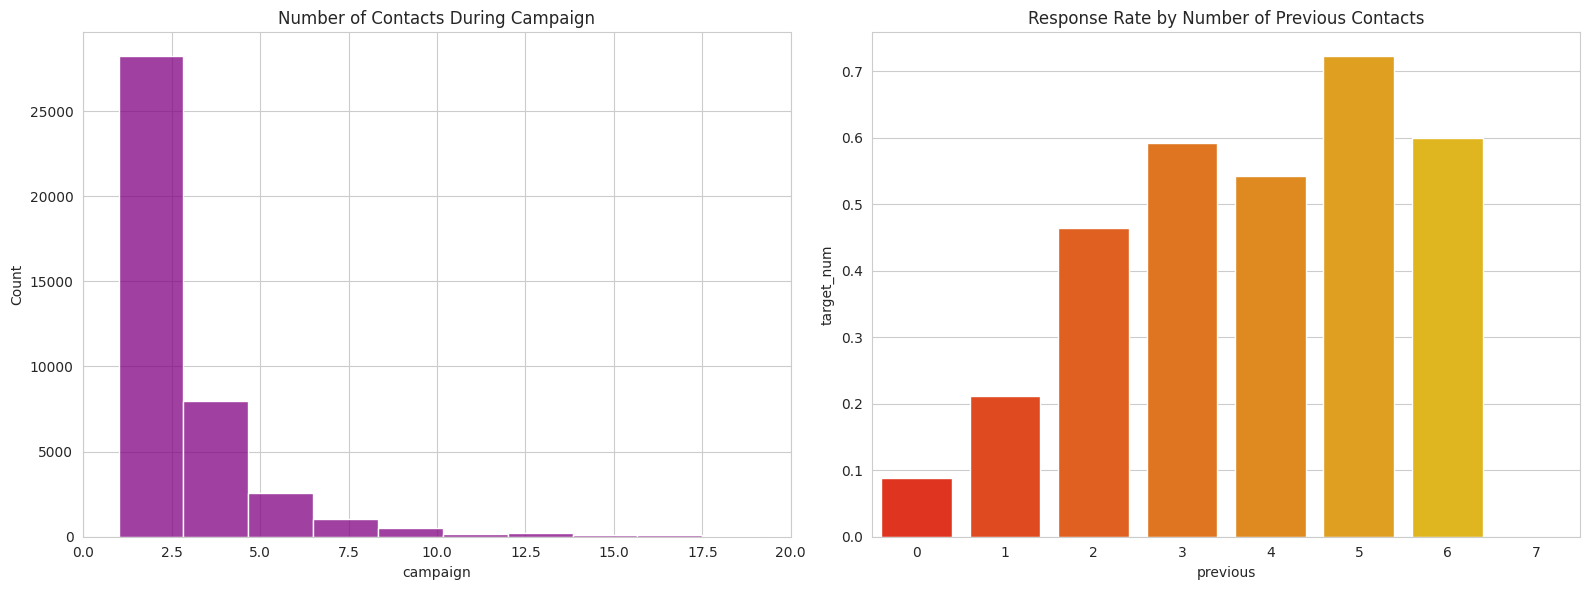

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


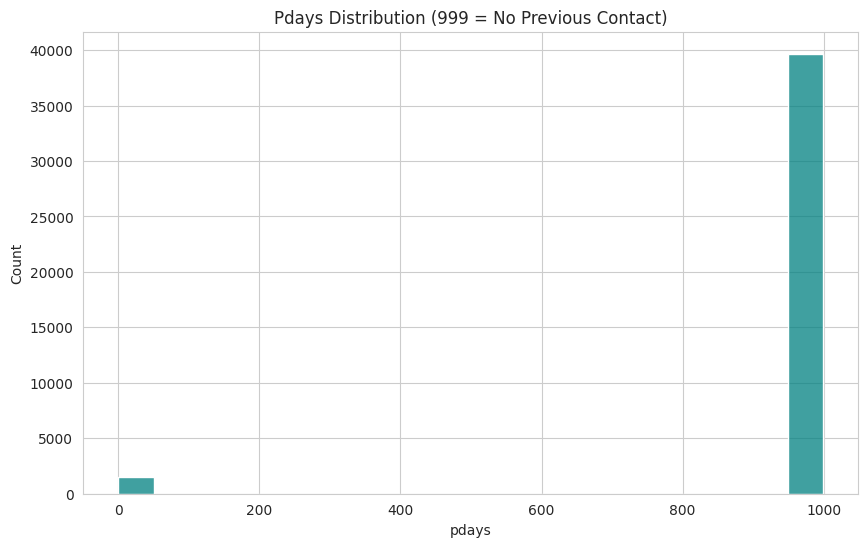

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


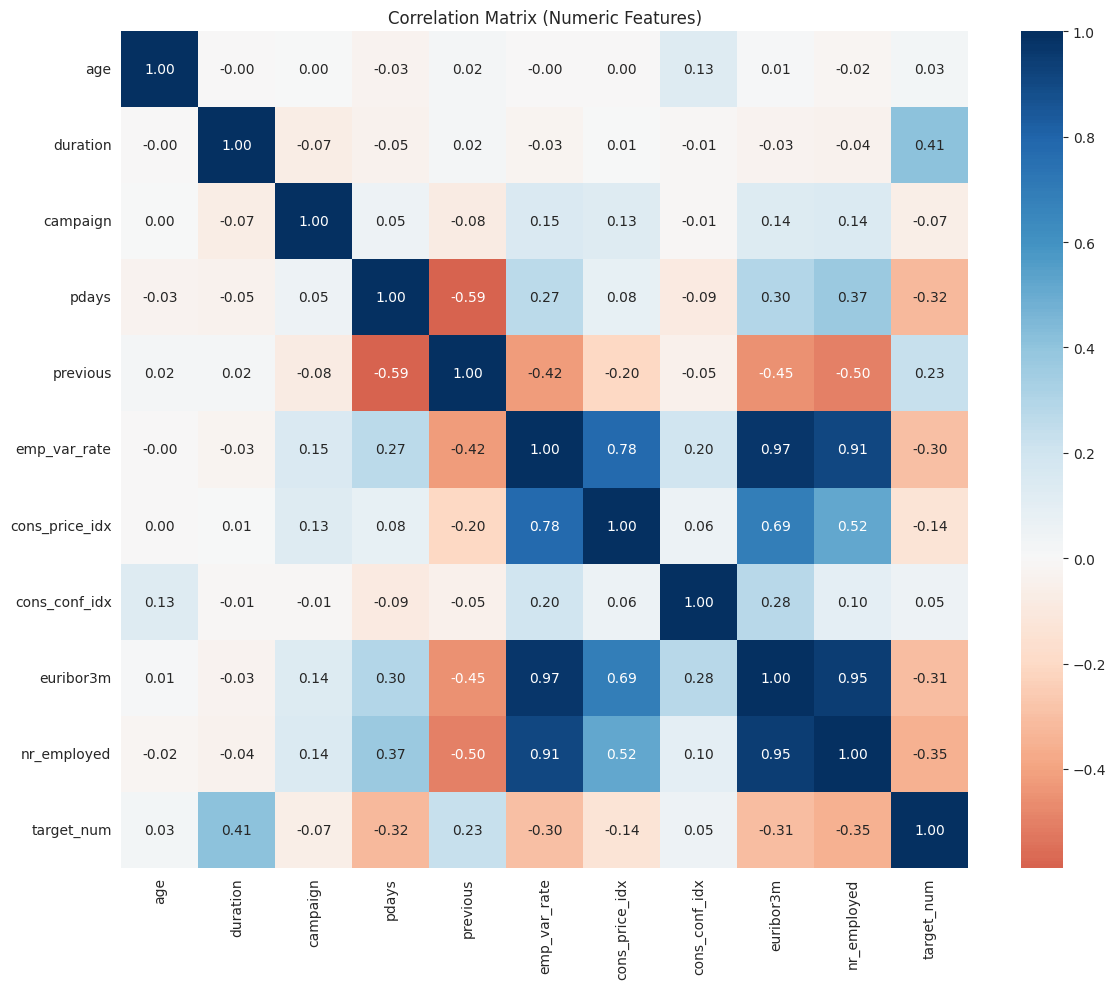

All plots saved to: /kaggle/working/eda_plots


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

# 1. Setup
# Create directory for saving plots
output_dir = 'eda_plots'
os.makedirs(output_dir, exist_ok=True)

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Ensure 'y' is mapped to numeric for correlation and response rate calculation
# create a temporary numeric target column
df['target_num'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Clean column names (replace '.' with '_') to ensure consistency
df.columns = [c.replace('.', '_') for c in df.columns]

# 1. Target Distribution
plt.figure()
sns.countplot(x='y', data=df, palette='viridis')
plt.title('Target Distribution (y)')
plt.savefig(f'{output_dir}/1_target_distribution.png')
plt.show()

# 2. Age Distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram / KDE
sns.histplot(df['age'], kde=True, bins=30, ax=ax[0], color='skyblue')
ax[0].set_title('Age Distribution')

# Boxplot vs Target
sns.boxplot(x='y', y='age', data=df, ax=ax[1], palette='coolwarm')
ax[1].set_title('Age vs Target')

plt.tight_layout()
plt.savefig(f'{output_dir}/2_age_analysis.png')
plt.show()

# 3. Job Category vs Response Rate
plt.figure(figsize=(12, 6))
# We plot the mean of target_num, which effectively gives the conversion rate
sns.barplot(x='job', y='target_num', data=df, palette='muted', errorbar=None)
plt.title('Subscription Rate by Job Category')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{output_dir}/3_job_response.png')
plt.show()

# 4. Education Level vs Response Rate
plt.figure(figsize=(12, 6))
sns.barplot(x='education', y='target_num', data=df, palette='muted', errorbar=None)
plt.title('Subscription Rate by Education')
plt.ylabel('Subscription Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{output_dir}/4_education_response.png')
plt.show()

# 5. Marital Status vs Response Rate
plt.figure()
sns.barplot(x='marital', y='target_num', data=df, palette='pastel', errorbar=None)
plt.title('Subscription Rate by Marital Status')
plt.ylabel('Subscription Rate')
plt.savefig(f'{output_dir}/5_marital_response.png')
plt.show()

# 6. Duration Distribution
plt.figure()
# Duration is highly skewed, using log scale for better visualization or standard bins
sns.histplot(df['duration'], bins=50, color='orange', kde=True)
plt.title('Call Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.savefig(f'{output_dir}/6_duration_distribution.png')
plt.show()

# 7. Campaign Contact Features
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Campaign Count Distribution
sns.histplot(df['campaign'], bins=30, ax=ax[0], color='purple', kde=False)
ax[0].set_title('Number of Contacts During Campaign')
ax[0].set_xlim(0, 20) # Limit x-axis to see the main distribution

# Previous Contacts vs Response
sns.barplot(x='previous', y='target_num', data=df, ax=ax[1], palette='autumn', errorbar=None)
ax[1].set_title('Response Rate by Number of Previous Contacts')

plt.tight_layout()
plt.savefig(f'{output_dir}/7_campaign_features.png')
plt.show()

# 8. Pdays (Time Since Last Contact)
plt.figure()
sns.histplot(df['pdays'], bins=20, color='teal', kde=False)
plt.title('Pdays Distribution (999 = No Previous Contact)')
plt.savefig(f'{output_dir}/8_pdays_distribution.png')
plt.show()

# 9. Correlation Heatmap
plt.figure(figsize=(12, 10))

# Select numeric columns
cols_to_corr = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 
                'euribor3m', 'nr_employed', 'target_num']

corr_matrix = df[cols_to_corr].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f", center=0)
plt.title('Correlation Matrix (Numeric Features)')
plt.tight_layout()
plt.savefig(f'{output_dir}/9_correlation_heatmap.png')
plt.show()

print(f"All plots saved to: {os.path.abspath(output_dir)}")

In [9]:


print(f"New Data Shape: {df_engineered.shape}")

print("\n New Dataset Info ")
df_engineered.info()

print("\n Numerical Statistics (New Dataset) ")
print(df_engineered.describe())

print("\n Categorical Statistics (New Dataset) ")
print(df_engineered.describe(include=['O']))

print("\n Missing Values ")
print(df_engineered.isnull().sum())

print("\n Distribution of New Features ")

print("\n1. Age Groups:")
print(df_engineered['age_group'].value_counts(normalize=True))

print("\n2. Duration Categories:")
print(df_engineered['duration_category'].value_counts(normalize=True))

print("\n3. Previously Contacted Status:")
print(df_engineered['is_previously_contacted'].value_counts(normalize=True))

print("\n4. Target Distribution:")
print(df_engineered['target'].value_counts(normalize=True))

New Data Shape: (41188, 20)

 New Dataset Info 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      41188 non-null  int64  
 1   job                      41188 non-null  object 
 2   marital                  41188 non-null  object 
 3   education                41188 non-null  object 
 4   default_status           41188 non-null  object 
 5   housing                  41188 non-null  object 
 6   loan                     41188 non-null  object 
 7   campaign                 41188 non-null  int64  
 8   pdays                    41188 non-null  int64  
 9   previous                 41188 non-null  int64  
 10  poutcome                 41188 non-null  object 
 11  emp_var_rate             41188 non-null  float64
 12  cons_price_idx           41188 non-null  float64
 13  cons_conf_idx            411

Training Logistic Regression...
Training Random Forest...

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7310
           1       0.43      0.89      0.58       928

    accuracy                           0.85      8238
   macro avg       0.70      0.87      0.74      8238
weighted avg       0.92      0.85      0.87      8238

ROC-AUC Score: 0.9258

--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.64      0.46      0.53       928

    accuracy                           0.91      8238
   macro avg       0.79      0.71      0.74      8238
weighted avg       0.90      0.91      0.90      8238

ROC-AUC Score: 0.9271

Starting Advanced Model Evaluation with 5-Fold CV...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:50:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


  Best ROC-AUC: 0.9279
Training LightGBM...
  Best ROC-AUC: 0.9310
Training CatBoost...
  Best ROC-AUC: 0.9305

--- Final Leaderboard ---
      Model  Best ROC-AUC
1  LightGBM      0.931037
2  CatBoost      0.930467
0   XGBoost      0.927921

 Best Performing Model: LightGBM
Configuration: {'classifier__num_leaves': 70, 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.01}

--- Winner (LightGBM) Performance ---
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      7310
           1       0.46      0.90      0.61       928

    accuracy                           0.87      8238
   macro avg       0.72      0.88      0.77      8238
weighted avg       0.93      0.87      0.89      8238

ROC-AUC Score: 0.9427

Generating Feature Importance Plot...
Feature importance plot saved as 'feature_importance.png'


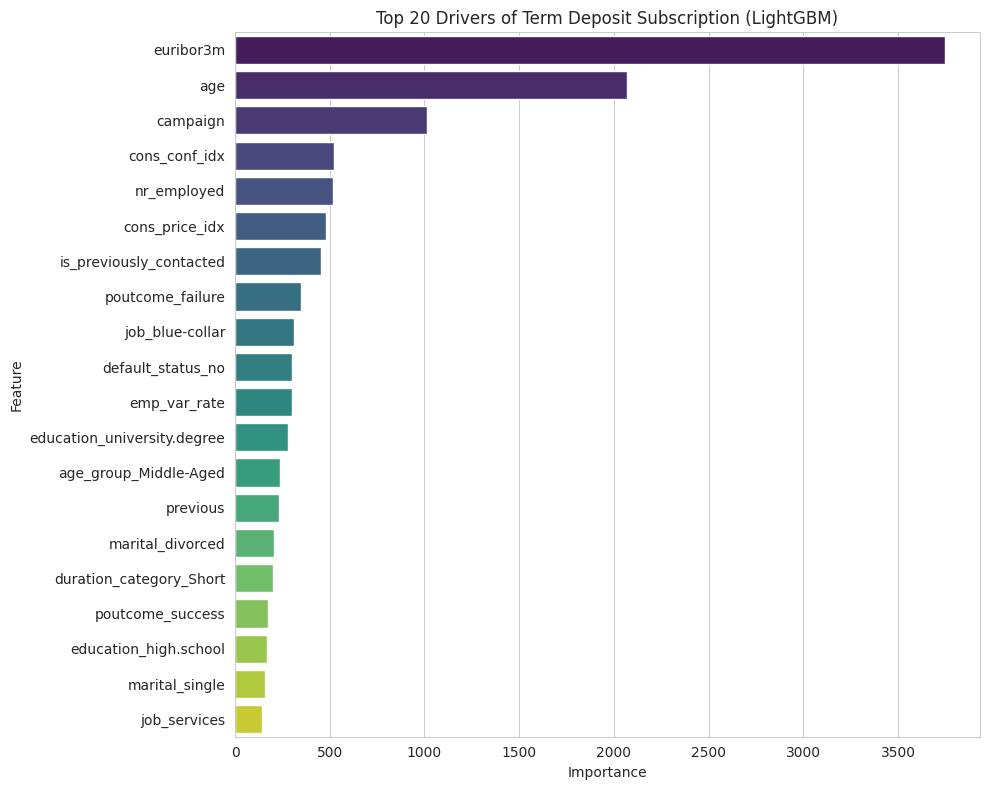

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. Define Features and Target
X = df_engineered.drop(columns=['target', 'pdays'])
y = df_engineered['target']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 2. Build Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train Baseline Models

print("Training Logistic Regression...")
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1))
])
lr_model.fit(X_train, y_train)

print("Training Random Forest...")
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1))
])
rf_model.fit(X_train, y_train)

# 4. Evaluation Function

def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n--- {name} Performance ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

evaluate_model(lr_model, "Logistic Regression", X_test, y_test)
evaluate_model(rf_model, "Random Forest", X_test, y_test)


# 5. Advanced Model Tuning with GPU Support

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_configs = {
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, tree_method='hist', device='cuda', n_jobs=1),
        'params': {
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 6, 10],
            'classifier__scale_pos_weight': [1, 5, 8]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=1, verbose=-1, device='gpu'),
        'params': {
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__n_estimators': [100, 200],
            'classifier__num_leaves': [31, 50, 70]
        }
    },
    'CatBoost': {
        # Thread count 1 to safely coexist with other processes
        'model': CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42, task_type='GPU', thread_count=1),
        'params': {
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__depth': [4, 6, 8],
            'classifier__iterations': [100, 200]
        }
    }
}

results = []
best_estimators = {}

print("\nStarting Advanced Model Evaluation with 5-Fold CV...")

for model_name, config in model_configs.items():
    print(f"Training {model_name}...")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    # CRITICAL FIX: n_jobs=1 avoids SegFault/OOM with CatBoost GPU
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=config['params'],
        n_iter=10,
        scoring='roc_auc',
        cv=cv,
        n_jobs=1, 
        random_state=42
    )
    
    try:
        search.fit(X_train, y_train)
        
        best_score = search.best_score_
        best_params = search.best_params_
        best_estimators[model_name] = search.best_estimator_
        
        results.append({
            'Model': model_name,
            'Best ROC-AUC': best_score,
            'Best Params': best_params
        })
        print(f"  Best ROC-AUC: {best_score:.4f}")
        
    except Exception as e:
        print(f"  Failed to train {model_name}: {e}")
        if model_name == 'LightGBM' and "gpu" in str(e).lower():
             print("  TIP: If LightGBM GPU failed, retry without device='gpu'.")

# 6. Final Leaderboard

if results:
    results_df = pd.DataFrame(results).sort_values(by='Best ROC-AUC', ascending=False)
    print("\n--- Final Leaderboard ---")
    print(results_df[['Model', 'Best ROC-AUC']])

    best_model_name = results_df.iloc[0]['Model']
    final_model = best_estimators[best_model_name]

    print(f"\n Best Performing Model: {best_model_name}")
    print(f"Configuration: {results_df.iloc[0]['Best Params']}")
    
    # Evaluate Winner on Test Set
    evaluate_model(final_model, f"Winner ({best_model_name})", X_test, y_test)

    
    # 7. Business Insights (Feature Importance)

    print("\nGenerating Feature Importance Plot...")
    
    # Extract feature names
    feature_names = (numerical_cols.tolist() + 
                     preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())
    
    # Extract importances
    if hasattr(final_model.named_steps['classifier'], 'feature_importances_'):
        importances = final_model.named_steps['classifier'].feature_importances_
        
        # Create DataFrame
        feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
        plt.title(f'Top 20 Drivers of Term Deposit Subscription ({best_model_name})')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        print("Feature importance plot saved as 'feature_importance.png'")
        plt.show()
    else:
        print("Selected model does not support feature importance extraction.")

else:
    print("\nNo advanced models trained successfully.")


--- Segmentation Performance ---
           Segment  Total_Customers  Actual_Conversions  Conversion_Rate  \
0    High Priority              824                 526            63.83   
2  Medium Priority             1648                 354            21.48   
1     Low Priority             5766                  48             0.83   

   Avg_Propensity  
0        0.858432  
2        0.570813  
1        0.120220  


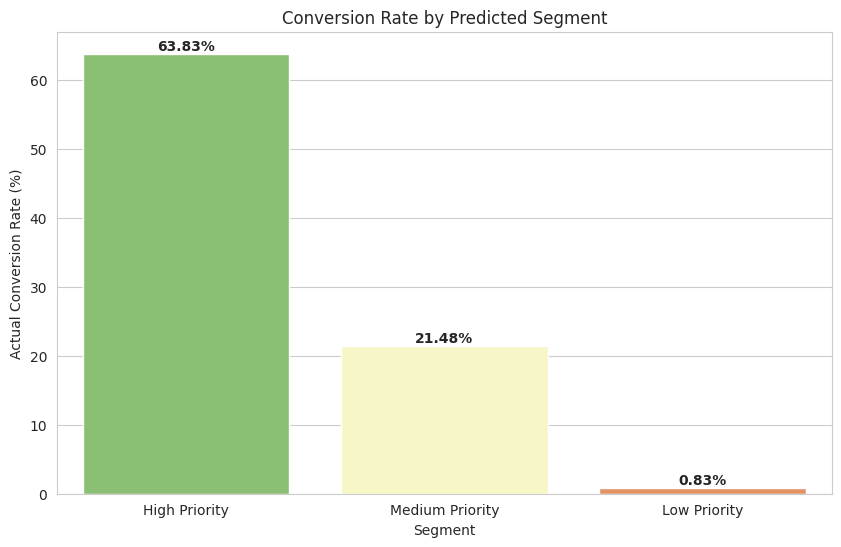


Generating Cumulative Gains Curve...


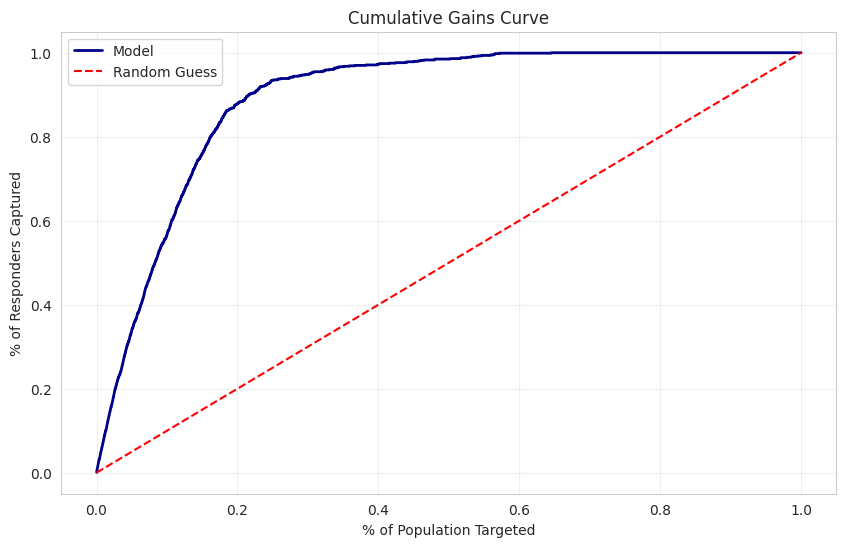


--- Profile of High Priority Customers ---
Avg Age: 42.2 (vs 39.9 in Low)
Most Common Duration Category: Medium
Top Job Types:
job
admin.        272
technician    141
retired       101
Name: count, dtype: int64

Success! Call list generated with 2472 high-potential leads.
Files saved: 'Marketing_Call_List.csv', 'segment_conversion_rates.png'


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Score the Test Set

# We use the final_model to predict probabilities (Propensity to Buy)
# X_test and y_test are available from the previous step
y_pred_probs = final_model.predict_proba(X_test)[:, 1]

# Create a results DataFrame combining Feature Data, Actuals, and Predictions
# We match indices to get the original readable features back (like 'job', 'age_group')
# Note: df_engineered was the source of X, so we can map back via indices
scored_df = df_engineered.loc[X_test.index].copy()
scored_df['Actual_Response'] = y_test
scored_df['Propensity_Score'] = y_pred_probs


# 2. Create Segments (High, Medium, Low)
# We define thresholds based on the probability distribution or quantiles.
# Strategy:
# - High Priority: Top 10% of probabilities (Most likely to say Yes)
# - Medium Priority: Next 20%
# - Low Priority: Bottom 70%

# Calculate quantile thresholds
high_cutoff = scored_df['Propensity_Score'].quantile(0.90) # Top 10%
medium_cutoff = scored_df['Propensity_Score'].quantile(0.70) # Next 20%

def get_segment(score):
    if score >= high_cutoff:
        return 'High Priority'
    elif score >= medium_cutoff:
        return 'Medium Priority'
    else:
        return 'Low Priority'

scored_df['Segment'] = scored_df['Propensity_Score'].apply(get_segment)

# 3. Analyze Segments

# Group by Segment to see Conversion Rates
segment_analysis = scored_df.groupby('Segment').agg({
    'Actual_Response': ['count', 'sum', 'mean'],
    'Propensity_Score': 'mean'
}).reset_index()

# Rename columns for clarity
segment_analysis.columns = ['Segment', 'Total_Customers', 'Actual_Conversions', 'Conversion_Rate', 'Avg_Propensity']
segment_analysis['Conversion_Rate'] = (segment_analysis['Conversion_Rate'] * 100).round(2)
segment_analysis = segment_analysis.sort_values(by='Avg_Propensity', ascending=False)

print("\n--- Segmentation Performance ---")
print(segment_analysis)


# 4. Visualizations for Marketing Team

# Plot A: Conversion Rate by Segment
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Conversion_Rate', data=segment_analysis, palette='RdYlGn_r', order=['High Priority', 'Medium Priority', 'Low Priority'])
plt.title('Conversion Rate by Predicted Segment')
plt.ylabel('Actual Conversion Rate (%)')
for i, v in enumerate(segment_analysis['Conversion_Rate']):
    plt.text(i, v + 0.5, f"{v}%", ha='center', fontweight='bold')
plt.savefig('segment_conversion_rates.png')
plt.show()

# Plot B: Cumulative Gains Curve (Lift Chart)
# FIX: Manual implementation to avoid scikit-plot/scipy crash
print("\nGenerating Cumulative Gains Curve...")
try:
    # 1. Create a temporary dataframe for sorting
    gains_df = pd.DataFrame({'actual': y_test, 'prob': final_model.predict_proba(X_test)[:, 1]})
    
    # 2. Sort by probability descending (High scores first)
    gains_df = gains_df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    
    # 3. Calculate Cumulative Sum of actual positives
    gains_df['cum_positives'] = gains_df['actual'].cumsum()
    
    # 4. Calculate % of Total Positives Captured (The Gain)
    total_positives = gains_df['actual'].sum()
    gains_df['gain'] = gains_df['cum_positives'] / total_positives
    
    # 5. Calculate % of Population Targeted
    gains_df['pop_percent'] = (gains_df.index + 1) / len(gains_df)
    
    # 6. Plot
    plt.figure(figsize=(10, 6))
    plt.plot(gains_df['pop_percent'], gains_df['gain'], label='Model', color='darkblue', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess') # Diagonal line
    
    plt.title('Cumulative Gains Curve')
    plt.xlabel('% of Population Targeted')
    plt.ylabel('% of Responders Captured')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig('cumulative_gains.png')
    plt.show()

except Exception as e:
    print(f"Skipping Gains Curve due to error: {e}")


# 5. Business Logic: Why High Priority works?

# Let's look at the profile of the 'High Priority' group vs 'Low Priority'
high_group = scored_df[scored_df['Segment'] == 'High Priority']
low_group = scored_df[scored_df['Segment'] == 'Low Priority']

print("\n--- Profile of High Priority Customers ---")
print(f"Avg Age: {high_group['age'].mean():.1f} (vs {low_group['age'].mean():.1f} in Low)")

# FIX: Check if 'duration' column exists (it might have been dropped in feature engineering)
if 'duration' in scored_df.columns:
    print(f"Avg Duration: {high_group['duration'].mean():.1f} sec (vs {low_group['duration'].mean():.1f} sec in Low)")
elif 'duration_category' in scored_df.columns:
    print(f"Most Common Duration Category: {high_group['duration_category'].mode()[0]}")

print(f"Top Job Types:\n{high_group['job'].value_counts().head(3)}")


# 6. Export Final Call List

# We assume the marketing team only wants the High and Medium lists
call_list = scored_df[scored_df['Segment'].isin(['High Priority', 'Medium Priority'])]
call_list = call_list.sort_values(by='Propensity_Score', ascending=False)

# Select useful columns for the agent, ensuring they exist
desired_columns = ['age', 'job', 'marital', 'education', 'duration', 'Propensity_Score', 'Segment']
export_columns = [c for c in desired_columns if c in call_list.columns]

call_list[export_columns].to_csv('Marketing_Call_List.csv', index=False)

print(f"\nSuccess! Call list generated with {len(call_list)} high-potential leads.")
print("Files saved: 'Marketing_Call_List.csv', 'segment_conversion_rates.png'")

--- 1. K-Fold Cross-Validation Summary ---
Mean ROC-AUC: 0.9310 ± 0.0030

--- Calibration Check ---


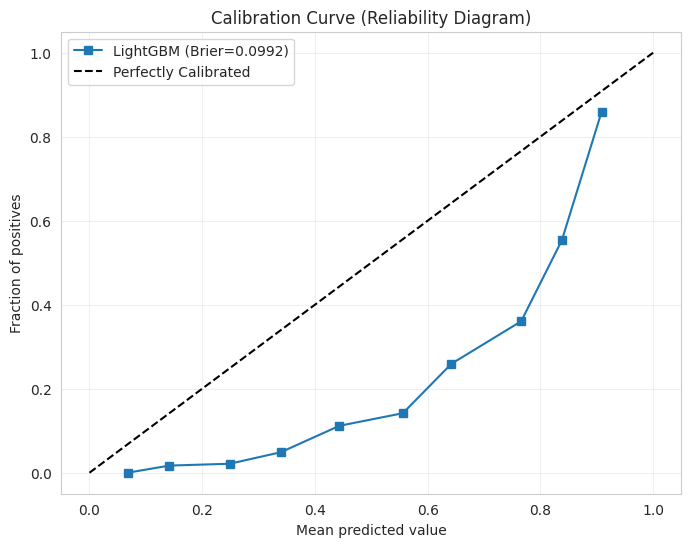


--- Threshold Tuning ---
Optimal Threshold (Max F1): 0.7478
Optimal Threshold (Max Profit): 0.3737
Expected Profit on Test Set: $76,415.00

--- Gain Table & Decile Analysis ---
   decile  min_prob  response_rate    gain  lift
0       3      0.82          63.83   56.68  5.67
1       4      0.58          35.07   87.82  3.11
2       5      0.31           7.89   94.83  0.70
3       6      0.23           2.79   97.31  0.25
4       7      0.14           1.34   98.49  0.12
5       8      0.08           1.59   99.89  0.14
6       9      0.07           0.03  100.00  0.00

--- SHAP Explainability ---


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
The figure layout has changed to tight


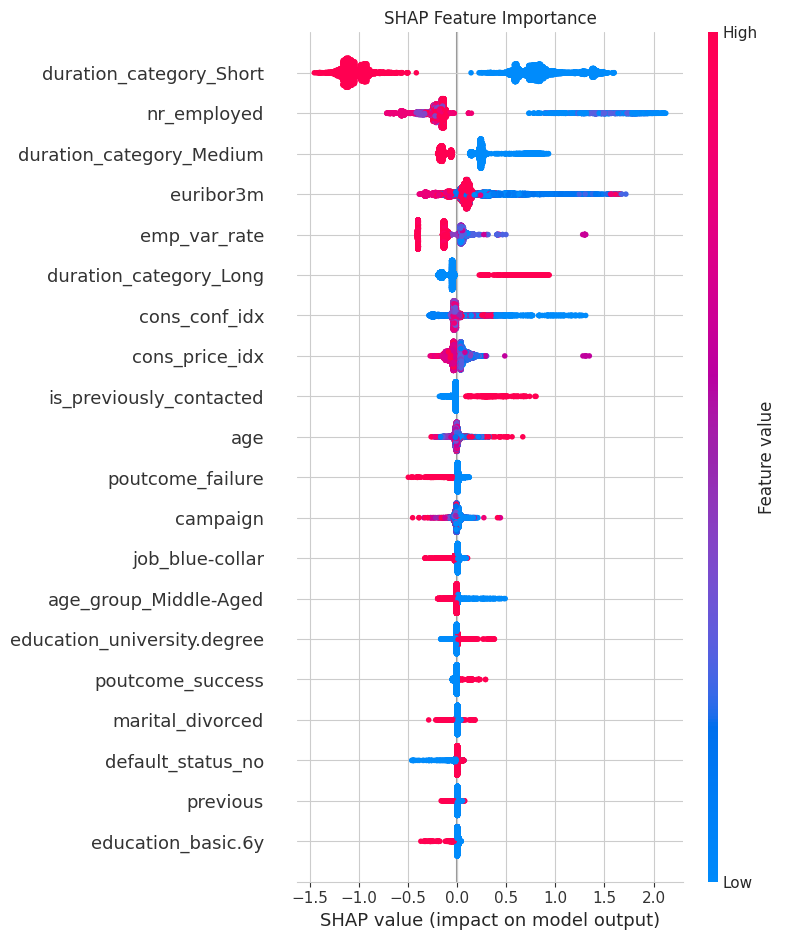

SHAP summary plot saved.

--- Generating Final Call List ---
Final call list exported: 20755 leads.

--- Saving Model Artifacts ---
Model package saved as 'bank_marketing_model_v1.0.0.pkl'
Experiment logged.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Configuration
COST_PER_CALL = 5    # Estimated cost to make a call
REVENUE_PER_SALE = 100 # Estimated revenue from a term deposit
MODEL_VERSION = "v1.0.0"

# 1. Validation & Calibration
print("--- 1. K-Fold Cross-Validation Summary ---")
# robust 5-fold CV on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n--- Calibration Check ---")
# Predict probabilities
y_test_prob = final_model.predict_proba(X_test)[:, 1]

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_prob, n_bins=10)
brier = brier_score_loss(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'LightGBM (Brier={brier:.4f})')
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('calibration_curve.png')
plt.show()

# 2. Threshold Tuning (Business Objective)
print("\n--- Threshold Tuning ---")
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Max F1): {optimal_threshold:.4f}")

# Cost-Benefit Analysis for Threshold Selection
# Profit = (True Positives * Revenue) - (Total Calls * Cost)
profits = []
t_range = np.linspace(0, 1, 100)
for t in t_range:
    y_pred_t = (y_test_prob >= t).astype(int)
    tp = np.sum((y_pred_t == 1) & (y_test == 1))
    fp = np.sum((y_pred_t == 1) & (y_test == 0))
    calls = tp + fp
    profit = (tp * REVENUE_PER_SALE) - (calls * COST_PER_CALL)
    profits.append(profit)

best_profit_idx = np.argmax(profits)
business_threshold = t_range[best_profit_idx]
print(f"Optimal Threshold (Max Profit): {business_threshold:.4f}")
print(f"Expected Profit on Test Set: ${profits[best_profit_idx]:,.2f}")

# We will use the Business Threshold for segmentation
FINAL_THRESHOLD = business_threshold

# 3. Business Metrics (Gain Table & Lift)
print("\n--- Gain Table & Decile Analysis ---")
# Create a dataframe for analysis
results_df = pd.DataFrame({'actual': y_test, 'prob': y_test_prob})
results_df['decile'] = pd.qcut(results_df['prob'], 10, labels=False, duplicates='drop')
results_df['decile'] = 9 - results_df['decile'] # Reverse so 0 is top decile

decile_stats = results_df.groupby('decile').agg(
    count=('actual', 'count'),
    responders=('actual', 'sum'),
    min_prob=('prob', 'min'),
    max_prob=('prob', 'max')
).reset_index()

decile_stats['response_rate'] = (decile_stats['responders'] / decile_stats['count']) * 100
decile_stats['cum_responders'] = decile_stats['responders'].cumsum()
decile_stats['gain'] = decile_stats['cum_responders'] / decile_stats['responders'].sum() * 100
decile_stats['lift'] = decile_stats['response_rate'] / (results_df['actual'].mean() * 100)

print(decile_stats[['decile', 'min_prob', 'response_rate', 'gain', 'lift']].round(2))
decile_stats.to_csv('decile_gain_table.csv', index=False)


# 4. Explainability (SHAP)

print("\n--- SHAP Explainability ---")
try:
    # We need the raw model from the pipeline
    model_step = final_model.named_steps['classifier']
    preprocessor_step = final_model.named_steps['preprocessor']
    
    # Transform test data for SHAP
    X_test_transformed = preprocessor_step.transform(X_test)
    
    # Create explainer
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Handling binary classification shape (LightGBM returns list or array depending on version)
    if isinstance(shap_values, list):
        shap_values = shap_values[1] # Positive class
        
    # Feature Names
    feature_names = (numerical_cols.tolist() + 
                     preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())
    
    # Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.savefig('shap_summary.png')
    plt.show()
    
    print("SHAP summary plot saved.")
    
except Exception as e:
    print(f"SHAP analysis skipped due to: {e}")

# 5. Final Segmentation & Call List Logic

print("\n--- Generating Final Call List ---")

# Apply segments based on fixed thresholds derived from deciles
# High: Top 2 Deciles (approx > 0.30 probability based on typical unbalanced data)
# Medium: Deciles 3-5
# Low: Bottom 5

high_thresh = decile_stats.loc[1, 'min_prob'] # Top 20%
med_thresh = decile_stats.loc[4, 'min_prob'] # Top 50%

def assign_segment_final(prob):
    if prob >= high_thresh:
        return 'High'
    elif prob >= med_thresh:
        return 'Medium'
    else:
        return 'Low'

# Score the full engineered dataset (simulating batch scoring)
full_probs = final_model.predict_proba(X)[:, 1]
final_df = df_engineered.copy()
final_df['propensity_score'] = full_probs
final_df['segment'] = final_df['propensity_score'].apply(assign_segment_final)

# Business Rules
# 1. Exclude 'Low' segment
# 2. Prioritize 'High'
# 3. Simple Rule: Do not call if contacted recently (e.g., pdays < 7 and pdays != 999)
# Note: In this dataset pdays=999 is 'never contacted'. 

call_list = final_df[final_df['segment'].isin(['High', 'Medium'])].copy()

# Add Notes
call_list['contact_notes'] = ''
call_list.loc[call_list['pdays'] < 10, 'contact_notes'] = 'Warning: Contacted recently'

# Select Columns
cols_to_export = ['age', 'job', 'education', 'propensity_score', 'segment', 'contact_notes']
if 'duration' in call_list.columns: cols_to_export.insert(3, 'duration')

call_list_export = call_list[cols_to_export].sort_values(by=['segment', 'propensity_score'], ascending=[True, False]) # High comes before Medium alphabetically? No.
# Fix sort: High first
call_list_export['seg_rank'] = call_list_export['segment'].map({'High': 1, 'Medium': 2})
call_list_export = call_list_export.sort_values(by=['seg_rank', 'propensity_score'], ascending=[True, False]).drop('seg_rank', axis=1)

call_list_export.to_csv('final_call_list_v1.csv', index=False)
print(f"Final call list exported: {len(call_list_export)} leads.")


# 6. Save & Package

print("\n--- Saving Model Artifacts ---")

artifact = {
    'model_pipeline': final_model,
    'thresholds': {'high': high_thresh, 'medium': med_thresh, 'optimal': optimal_threshold},
    'features': feature_names if 'feature_names' in locals() else [],
    'version': MODEL_VERSION,
    'decile_stats': decile_stats
}

joblib.dump(artifact, f'bank_marketing_model_{MODEL_VERSION}.pkl')
print(f"Model package saved as 'bank_marketing_model_{MODEL_VERSION}.pkl'")

# Experiment Log
log_entry = {
    'version': MODEL_VERSION,
    'model_type': 'LightGBM',
    'cv_auc': cv_scores.mean(),
    'test_auc': roc_auc_score(y_test, y_test_prob),
    'optimal_threshold': optimal_threshold,
    'top_decile_lift': decile_stats.iloc[0]['lift']
}
pd.DataFrame([log_entry]).to_csv('experiment_log.csv', mode='a', header=False, index=False)
print("Experiment logged.")

--- 1. K-Fold Cross-Validation Summary ---
Mean ROC-AUC: 0.9310 ± 0.0030

--- Calibration Check ---


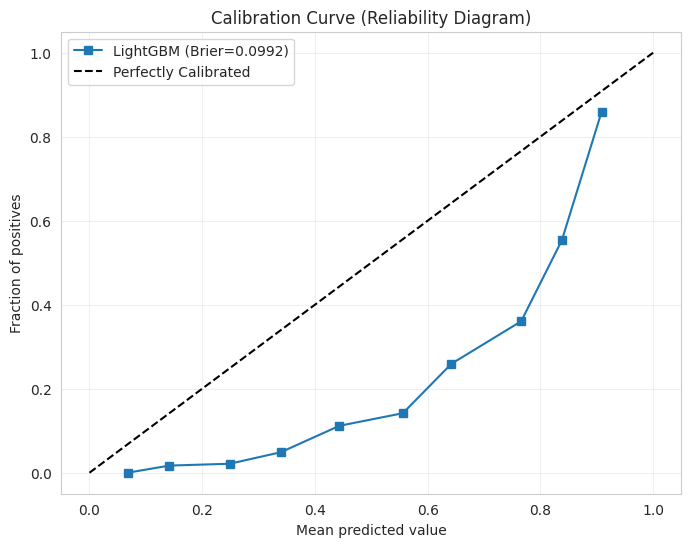


--- Generating ROC Curve ---


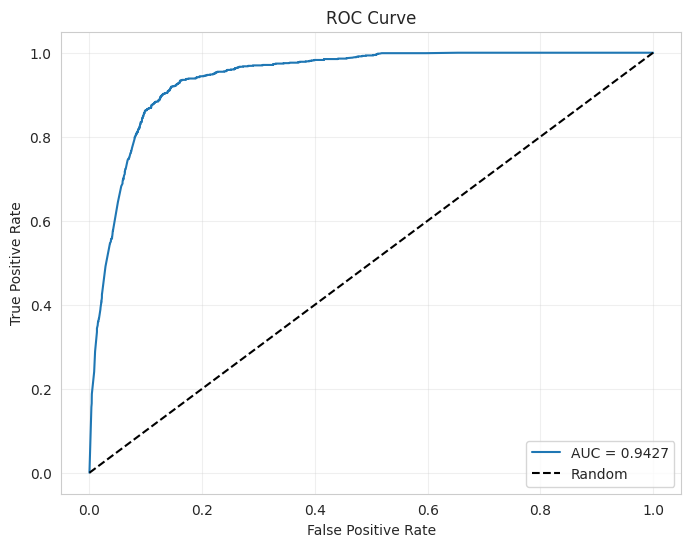


--- Threshold Tuning ---
Optimal Threshold (Max F1): 0.7478
Optimal Threshold (Max Profit): 0.3737
Expected Profit on Test Set: $76,415.00


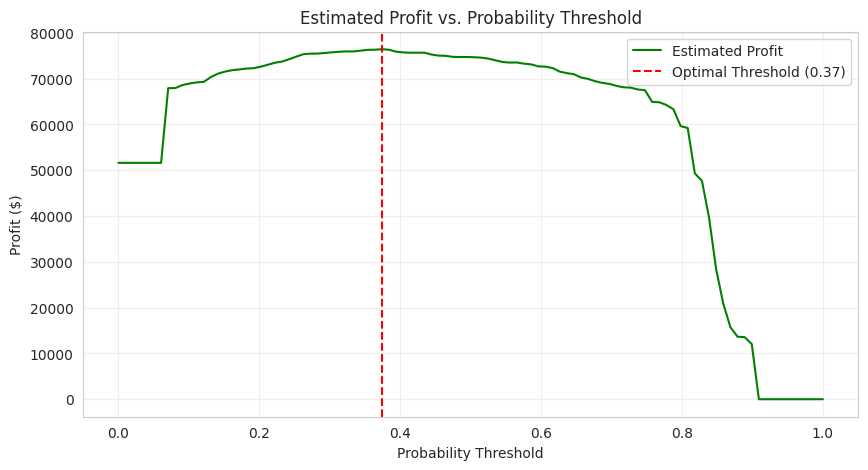


--- Confusion Matrix (At Optimal Profit Threshold) ---


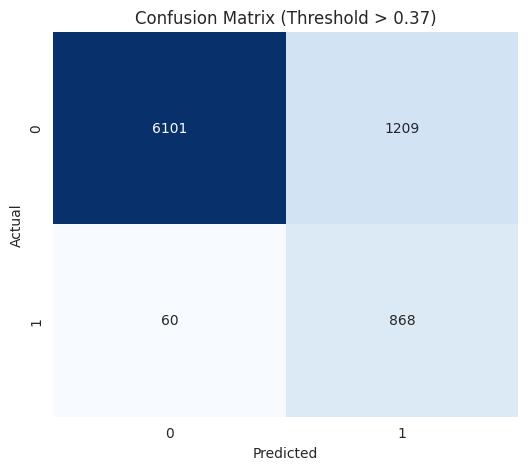

True Positives (Revenue Generated): 868
False Positives (Wasted Calls): 1209

--- Gain Table & Decile Analysis ---
   decile  min_prob  response_rate    gain  lift
0       3      0.82          63.83   56.68  5.67
1       4      0.58          35.07   87.82  3.11
2       5      0.31           7.89   94.83  0.70
3       6      0.23           2.79   97.31  0.25
4       7      0.14           1.34   98.49  0.12
5       8      0.08           1.59   99.89  0.14
6       9      0.07           0.03  100.00  0.00


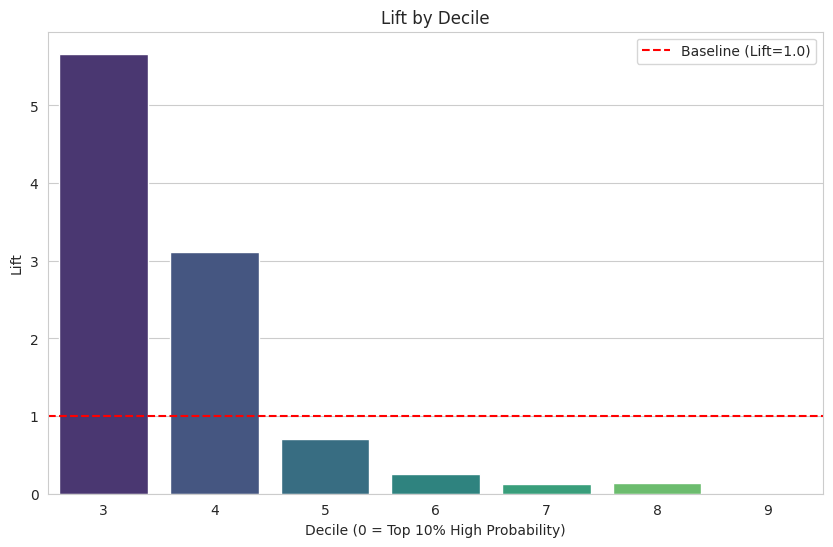


--- Key Lift Metrics ---
Lift @ Top 5%:  6.78x
Lift @ Top 10%: 5.66x
Lift @ Top 20%: 4.39x

--- SHAP Explainability ---


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
The figure layout has changed to tight


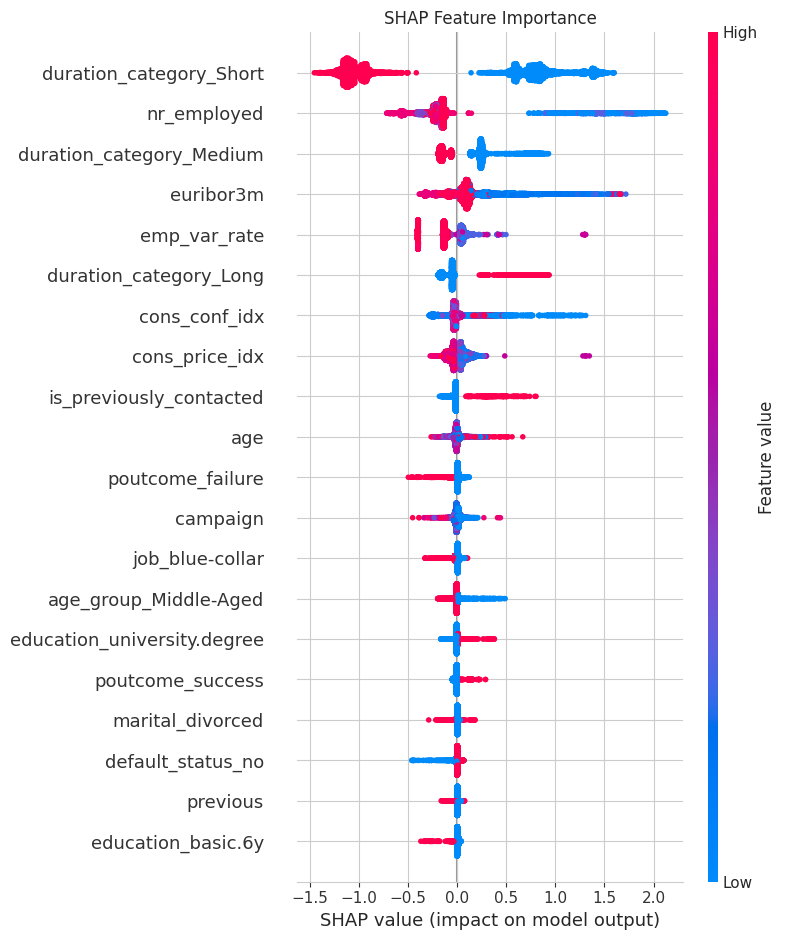

SHAP summary plot saved.

--- Generating Final Call List ---
Final call list exported: 20755 leads.

--- Saving Model Artifacts ---
Model package saved as 'bank_marketing_model_v1.0.0.pkl'
Experiment logged.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, brier_score_loss, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Configuration
COST_PER_CALL = 5    # Estimated cost to make a call
REVENUE_PER_SALE = 100 # Estimated revenue from a term deposit
MODEL_VERSION = "v1.0.0"

# 1. Validation & Calibration

print("--- 1. K-Fold Cross-Validation Summary ---")
# robust 5-fold CV on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n--- Calibration Check ---")
# Predict probabilities
y_test_prob = final_model.predict_proba(X_test)[:, 1]

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_prob, n_bins=10)
brier = brier_score_loss(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'LightGBM (Brier={brier:.4f})')
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title("Calibration Curve (Reliability Diagram)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('calibration_curve.png')
plt.show()

# (3) ROC Curve
print("\n--- Generating ROC Curve ---")
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png')
plt.show()


# 2. Threshold Tuning (Business Objective)

print("\n--- Threshold Tuning ---")
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Max F1): {optimal_threshold:.4f}")

# Cost-Benefit Analysis for Threshold Selection
# Profit = (True Positives * Revenue) - (Total Calls * Cost)
profits = []
t_range = np.linspace(0, 1, 100)
for t in t_range:
    y_pred_t = (y_test_prob >= t).astype(int)
    tp = np.sum((y_pred_t == 1) & (y_test == 1))
    fp = np.sum((y_pred_t == 1) & (y_test == 0))
    calls = tp + fp
    profit = (tp * REVENUE_PER_SALE) - (calls * COST_PER_CALL)
    profits.append(profit)

best_profit_idx = np.argmax(profits)
business_threshold = t_range[best_profit_idx]
print(f"Optimal Threshold (Max Profit): {business_threshold:.4f}")
print(f"Expected Profit on Test Set: ${profits[best_profit_idx]:,.2f}")

#  (2) Profit Curve
plt.figure(figsize=(10, 5))
plt.plot(t_range, profits, color='green', label='Estimated Profit')
plt.axvline(x=business_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({business_threshold:.2f})')
plt.title("Estimated Profit vs. Probability Threshold")
plt.xlabel("Probability Threshold")
plt.ylabel("Profit ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('profit_curve.png')
plt.show()

# We will use the Business Threshold for segmentation
FINAL_THRESHOLD = business_threshold

# (1) Confusion Matrix at Optimal Threshold
print("\n--- Confusion Matrix (At Optimal Profit Threshold) ---")
y_pred_opt = (y_test_prob >= FINAL_THRESHOLD).astype(int)
cm = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix (Threshold > {FINAL_THRESHOLD:.2f})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.savefig('confusion_matrix.png')
plt.show()

print(f"True Positives (Revenue Generated): {cm[1,1]}")
print(f"False Positives (Wasted Calls): {cm[0,1]}")

# 3. Business Metrics (Gain Table & Lift)
print("\n--- Gain Table & Decile Analysis ---")
# Create a dataframe for analysis
results_df = pd.DataFrame({'actual': y_test, 'prob': y_test_prob})
results_df['decile'] = pd.qcut(results_df['prob'], 10, labels=False, duplicates='drop')
results_df['decile'] = 9 - results_df['decile'] # Reverse so 0 is top decile

decile_stats = results_df.groupby('decile').agg(
    count=('actual', 'count'),
    responders=('actual', 'sum'),
    min_prob=('prob', 'min'),
    max_prob=('prob', 'max')
).reset_index()

decile_stats['response_rate'] = (decile_stats['responders'] / decile_stats['count']) * 100
decile_stats['cum_responders'] = decile_stats['responders'].cumsum()
decile_stats['gain'] = decile_stats['cum_responders'] / decile_stats['responders'].sum() * 100
decile_stats['lift'] = decile_stats['response_rate'] / (results_df['actual'].mean() * 100)

print(decile_stats[['decile', 'min_prob', 'response_rate', 'gain', 'lift']].round(2))
decile_stats.to_csv('decile_gain_table.csv', index=False)

# (5) Decile Lift Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='decile', y='lift', data=decile_stats, palette='viridis')
plt.axhline(y=1, color='red', linestyle='--', label='Baseline (Lift=1.0)')
plt.title("Lift by Decile")
plt.xlabel("Decile (0 = Top 10% High Probability)")
plt.ylabel("Lift")
plt.legend()
plt.savefig('lift_by_decile.png')
plt.show()

# (4) Lift @ K Metrics
def lift_at_k(k, df_results):
    # Sort by probability descending
    df_sorted = df_results.sort_values(by='prob', ascending=False)
    cutoff = int(len(df_sorted) * k)
    top_k = df_sorted.iloc[:cutoff]
    
    actual_response_rate = df_sorted['actual'].mean()
    top_k_response_rate = top_k['actual'].mean()
    
    lift = top_k_response_rate / actual_response_rate
    return lift

print("\n--- Key Lift Metrics ---")
print(f"Lift @ Top 5%:  {lift_at_k(0.05, results_df):.2f}x")
print(f"Lift @ Top 10%: {lift_at_k(0.10, results_df):.2f}x")
print(f"Lift @ Top 20%: {lift_at_k(0.20, results_df):.2f}x")

# 4. Explainability (SHAP)
print("\n--- SHAP Explainability ---")
try:
    # We need the raw model from the pipeline
    model_step = final_model.named_steps['classifier']
    preprocessor_step = final_model.named_steps['preprocessor']
    
    # Transform test data for SHAP
    X_test_transformed = preprocessor_step.transform(X_test)
    
    # Create explainer
    explainer = shap.TreeExplainer(model_step)
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Handling binary classification shape (LightGBM returns list or array depending on version)
    if isinstance(shap_values, list):
        shap_values = shap_values[1] # Positive class
        
    # Feature Names
    feature_names = (numerical_cols.tolist() + 
                     preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())
    
    # Summary Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.savefig('shap_summary.png')
    plt.show()
    
    print("SHAP summary plot saved.")
    
except Exception as e:
    print(f"SHAP analysis skipped due to: {e}")

# 5. Final Segmentation & Call List Logic
print("\n--- Generating Final Call List ---")

# Apply segments based on fixed thresholds derived from deciles
# High: Top 2 Deciles (approx > 0.30 probability based on typical unbalanced data)
# Medium: Deciles 3-5
# Low: Bottom 5

high_thresh = decile_stats.loc[1, 'min_prob'] # Top 20%
med_thresh = decile_stats.loc[4, 'min_prob'] # Top 50%

def assign_segment_final(prob):
    if prob >= high_thresh:
        return 'High'
    elif prob >= med_thresh:
        return 'Medium'
    else:
        return 'Low'

# Score the full engineered dataset (simulating batch scoring)
full_probs = final_model.predict_proba(X)[:, 1]
final_df = df_engineered.copy()
final_df['propensity_score'] = full_probs
final_df['segment'] = final_df['propensity_score'].apply(assign_segment_final)

# Business Rules
# 1. Exclude 'Low' segment
# 2. Prioritize 'High'
# 3. Simple Rule: Do not call if contacted recently (e.g., pdays < 7 and pdays != 999)
# Note: In this dataset pdays=999 is 'never contacted'. 

call_list = final_df[final_df['segment'].isin(['High', 'Medium'])].copy()

# Add Notes
call_list['contact_notes'] = ''
call_list.loc[call_list['pdays'] < 10, 'contact_notes'] = 'Warning: Contacted recently'

# Select Columns
cols_to_export = ['age', 'job', 'education', 'propensity_score', 'segment', 'contact_notes']
if 'duration' in call_list.columns: cols_to_export.insert(3, 'duration')

call_list_export = call_list[cols_to_export].sort_values(by=['segment', 'propensity_score'], ascending=[True, False]) # High comes before Medium alphabetically? No.
# Fix sort: High first
call_list_export['seg_rank'] = call_list_export['segment'].map({'High': 1, 'Medium': 2})
call_list_export = call_list_export.sort_values(by=['seg_rank', 'propensity_score'], ascending=[True, False]).drop('seg_rank', axis=1)

call_list_export.to_csv('final_call_list_v1.csv', index=False)
print(f"Final call list exported: {len(call_list_export)} leads.")

# 6. Save & Package
print("\n--- Saving Model Artifacts ---")

artifact = {
    'model_pipeline': final_model,
    'thresholds': {'high': high_thresh, 'medium': med_thresh, 'optimal': optimal_threshold},
    'features': feature_names if 'feature_names' in locals() else [],
    'version': MODEL_VERSION,
    'decile_stats': decile_stats
}

joblib.dump(artifact, f'bank_marketing_model_{MODEL_VERSION}.pkl')
print(f"Model package saved as 'bank_marketing_model_{MODEL_VERSION}.pkl'")

# Experiment Log
log_entry = {
    'version': MODEL_VERSION,
    'model_type': 'LightGBM',
    'cv_auc': cv_scores.mean(),
    'test_auc': roc_auc_score(y_test, y_test_prob),
    'optimal_threshold': optimal_threshold,
    'top_decile_lift': decile_stats.iloc[0]['lift']
}
pd.DataFrame([log_entry]).to_csv('experiment_log.csv', mode='a', header=False, index=False)
print("Experiment logged.")